In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
import datetime as dt
import os
import warnings
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

# Engenharia de Features

In [2]:
def load_data(dataset):
    path = f'../data/olist_{dataset}_dataset.parquet'
    return pd.read_parquet(path=path)

In [3]:
customers = load_data('customers')
geolocation = load_data('geolocation')
order_items = load_data('order_items')
order_payments = load_data('order_payments')
order_reviews = load_data('order_reviews')
orders = load_data('orders')
products = load_data('products')
sellers = load_data('sellers')

In [4]:
#união de clientes e pedidos
customers_orders = pd.merge(customers, orders, on='customer_id', how='inner')

## Clientes e pedidos

In [5]:
customers_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00


In [6]:
customers_orders.count()

customer_id                      99441
customer_unique_id               99441
customer_zip_code_prefix         99441
customer_city                    99441
customer_state                   99441
order_id                         99441
order_status                     99441
order_purchase_timestamp         99441
order_approved_at                99281
order_delivered_carrier_date     97658
order_delivered_customer_date    96476
order_estimated_delivery_date    99441
dtype: int64

## Duplicatas

In [7]:
print(f'{customers_orders.duplicated().sum()} registros duplicados')

0 registros duplicados


## Nulos

In [8]:
customers_orders.isnull().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [9]:
customers_orders.dropna(inplace=True)

In [10]:
total_clientes_mulitplas_compras = customers_orders['customer_unique_id'].duplicated().sum()
print(f'{total_clientes_mulitplas_compras} Clientes compraram mais de uma vez')

3119 Clientes compraram mais de uma vez


## Distribuição - Order Status

In [11]:
customers_orders['order_status'].value_counts()

order_status
delivered    96455
canceled         6
Name: count, dtype: int64

order_status
canceled         6
delivered    93336
Name: customer_unique_id, dtype: int64


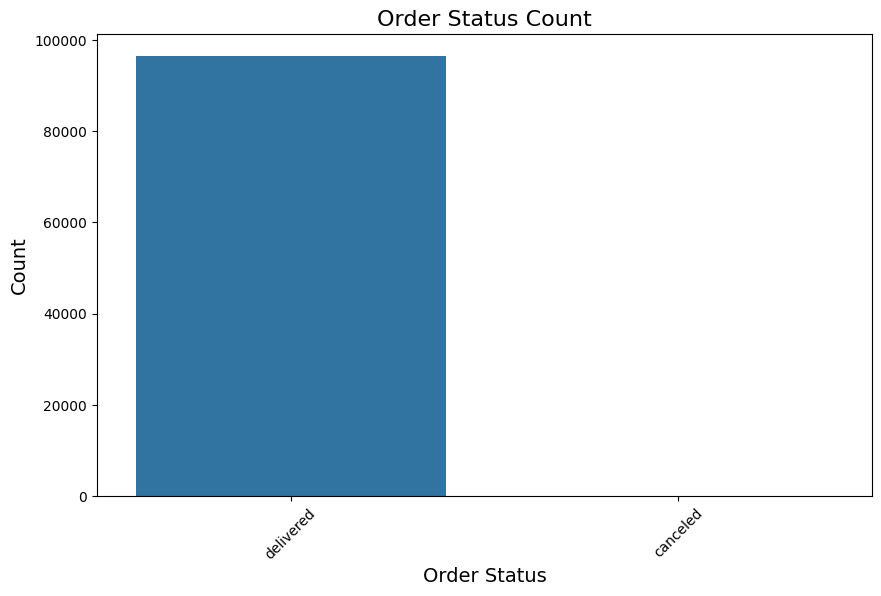

In [12]:
print(customers_orders.groupby('order_status')['customer_unique_id'].nunique())

plt.figure(figsize=(10,6))
sns.countplot(x='order_status', data=customers_orders)
plt.title('Order Status Count', fontsize=16)
plt.xlabel('Order Status', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Certificando tipagem de dados - DATAS

In [13]:
customers_orders['order_purchase_timestamp'] = pd.to_datetime(customers_orders['order_purchase_timestamp'])
customers_orders['order_approved_at'] = pd.to_datetime(customers_orders['order_approved_at'])
customers_orders['order_delivered_carrier_date'] = pd.to_datetime(customers_orders['order_delivered_carrier_date'])
customers_orders['order_delivered_customer_date'] = pd.to_datetime(customers_orders['order_delivered_customer_date'])
customers_orders['order_estimated_delivery_date'] = pd.to_datetime(customers_orders['order_estimated_delivery_date'])

# Mudando formato para YYYY-MM-DD

In [14]:
customers_orders['order_purchase_timestamp'] = customers_orders['order_purchase_timestamp'].dt.strftime('%Y-%m-%d')
customers_orders['order_approved_at'] = customers_orders['order_approved_at'].dt.strftime('%Y-%m-%d')
customers_orders['order_delivered_carrier_date'] = customers_orders['order_delivered_carrier_date'].dt.strftime('%Y-%m-%d')
customers_orders['order_delivered_customer_date'] = customers_orders['order_delivered_customer_date'].dt.strftime('%Y-%m-%d')
customers_orders['order_estimated_delivery_date'] = customers_orders['order_estimated_delivery_date'].dt.strftime('%Y-%m-%d')

In [15]:
customers_orders['on_time_delivery'] = np.where(customers_orders['order_estimated_delivery_date'] == customers_orders['order_delivered_customer_date'], 'Yes', 'No')

## Entregas que foram feitas no tempo estimado

In [16]:
customers_orders['on_time_delivery'].value_counts()

on_time_delivery
No     95169
Yes     1292
Name: count, dtype: int64

## Checando aprovação de pedidos antes da compra:

In [17]:
customers_orders.where(customers_orders['order_approved_at'] < customers_orders['order_purchase_timestamp']).count()

customer_id                      0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_id                         0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
on_time_delivery                 0
dtype: int64

## Extraindo a diferença entre a compra e aprovação

In [18]:
customers_orders['order_purchase_timestamp'] = pd.to_datetime(customers_orders['order_purchase_timestamp'])
customers_orders['order_approved_at'] = pd.to_datetime(customers_orders['order_approved_at'])
customers_orders['approved_date'] = customers_orders['order_purchase_timestamp'] - customers_orders['order_approved_at']
customers_orders['approved_date'] = customers_orders['approved_date'].dt.days

In [19]:
customers_orders['approved_date'].value_counts()

approved_date
 0     66843
-1     16674
-2      8901
-3      2201
-4      1314
-5       384
-6        58
-7        28
-12       13
-11       13
-8        13
-9         6
-13        5
-10        4
-31        2
-17        1
-23        1
Name: count, dtype: int64

Percebemos que não há casos onde a aprovação foi feita antes da compra e estas são aprovadas entre os primeiros dias.

In [20]:
customers_orders['order_delivered_carrier_date'] = pd.to_datetime(customers_orders['order_delivered_carrier_date'])
customers_orders['order_delivered_customer_date'] = pd.to_datetime(customers_orders['order_delivered_customer_date'])

In [21]:
customers_orders_payments = pd.merge(customers_orders, order_payments, on='order_id', how='inner')
customers_orders_payments.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,on_time_delivery,approved_date,payment_sequential,payment_type,payment_installments,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16,2017-05-16,2017-05-23,2017-05-25,2017-06-05,No,0,1,credit_card,2,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12,2018-01-12,2018-01-15,2018-01-29,2018-02-06,No,0,1,credit_card,8,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19,2018-05-20,2018-06-11,2018-06-14,2018-06-13,No,-1,1,credit_card,7,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13,2018-03-13,2018-03-27,2018-03-28,2018-04-10,No,0,1,credit_card,1,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29,2018-07-29,2018-07-30,2018-08-09,2018-08-15,No,0,1,credit_card,8,252.25


## Número de pedidos por clientes

In [22]:
customers_orders_payments['number_of_orders'] = customers_orders_payments.groupby('customer_unique_id')['order_id'].transform('count')
customers_orders_payments['number_of_orders'].value_counts()


number_of_orders
1     87878
2      9160
3      1572
4       624
5       350
6       294
7       210
8        96
9        81
11       77
12       60
13       52
15       45
14       42
10       40
19       38
33       33
26       26
23       23
22       22
16       16
Name: count, dtype: int64

In [23]:
percentage_of_multiple_sales = customers_orders_payments[customers_orders_payments['number_of_orders'] > 1]['customer_unique_id'].nunique()/customers_orders_payments['customer_unique_id'].nunique()*100
print(f"Apenas {percentage_of_multiple_sales:.2f}% dos clientes compraram mais de uma vez!")

Apenas 5.85% dos clientes compraram mais de uma vez!


#### Apenas 5.85% dos clientes compraram novamente!

Isso signfica que o Churn dessa amostragem é extremamente alto.

# Datas Comerciais

In [24]:
commerce_dates = pd.read_parquet("../data/feriados_comerciais.parquet")
commerce_dates

,Anos,Datas,Nomes
0,2016,2016-01-01,Reveillon
1,2016,2016-03-08,Dia da Mulher
2,2016,2016-03-26,Pascoa
3,2016,2016-05-08,Dia das Maes
4,2016,2016-06-12,Dia dos Namorados
5,2016,2016-08-14,Dia dos Pais
6,2016,2016-10-12,Dia das Criancas
7,2016,2016-11-25,Black Friday
8,2016,2016-12-25,Natal
9,2017,2017-01-01,Reveillon


In [25]:
customers_orders_payments['order_purchase_timestamp'] = pd.to_datetime(customers_orders_payments['order_purchase_timestamp'])
commerce_dates['Datas'] = pd.to_datetime(commerce_dates['Datas'])

In [26]:
def find_closest_date(order_date):
    diffs = np.abs((commerce_dates['Datas'] - order_date).dt.days)
    closest_index = diffs.argmin()
    return commerce_dates.iloc[closest_index]

In [27]:
closest_dates = customers_orders_payments['order_purchase_timestamp'].apply(find_closest_date)

In [28]:
customers_orders_payments['comdate_diff'] = (customers_orders_payments['order_purchase_timestamp'] - closest_dates['Datas']).dt.days
customers_orders_payments['commercial_date_names'] = closest_dates['Nomes']
customers_orders_payments['commercial_dates'] = closest_dates['Datas']
customers_orders_payments['order_week_before_comdate'] = (customers_orders_payments['comdate_diff'] >= -7) & (customers_orders_payments['order_purchase_timestamp'] <= closest_dates['Datas'])
customers_orders_payments['order_week_before_comdate'] = customers_orders_payments['order_week_before_comdate'].replace({True: 'Yes', False: 'No'})

#### Verificando quais compras foram realizadas 1 semana antes de uma data comercial

In [29]:
display(customers_orders_payments['order_week_before_comdate'].value_counts())
alt.Chart(customers_orders_payments).mark_bar().encode(
    alt.X('order_week_before_comdate'),
    alt.Y('count()', title='Week Before Commercial Date Count')
    ).properties(
        title='Week Before Commercial Date Count'
    )

order_week_before_comdate
No     81082
Yes    19657
Name: count, dtype: int64

alt.Chart(...)

# Unindo o dataset de produtos
Na intenção de extrair as categorias significativas

In [30]:
customers_orders_payments_items = pd.merge(
    customers_orders_payments, order_items, on='order_id', how='inner')
customer_products = customers_orders_payments_items.merge(
    products, on='product_id', how='inner'
)
customer_products.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16,2017-05-16,2017-05-23,...,124.99,21.88,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12,2018-01-12,2018-01-15,...,289.00,46.48,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19,2018-05-20,2018-06-11,...,139.94,17.79,moveis_escritorio,55.0,955.0,1.0,8267.0,52.0,52.0,17.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13,2018-03-13,2018-03-27,...,149.94,23.36,moveis_escritorio,48.0,1066.0,1.0,12160.0,56.0,51.0,28.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29,2018-07-29,2018-07-30,...,230.00,22.25,casa_conforto,61.0,407.0,1.0,5200.0,45.0,15.0,35.0


## Distribuição de categorias

In [31]:
count_category = customer_products['product_category_name'].value_counts()
alt.Chart(customer_products).mark_bar().encode(
    alt.Y('product_category_name', title='Categories').sort('-x'),
    alt.X('count()', title='Category Sales')
    ).properties(
        title='Category Sales'
    )

alt.Chart(...)

Há uma quantidade muito grande de categorias que não são tão expressivas para o modelo de sensibilidade sazonal, portanto está decidida a realização de um corte para o uso das apenas das categorias que estão dentro dos 20% mais vendidas.

In [32]:
category_cut = int(customer_products['product_category_name'].nunique() * 0.2)
top_20percent_category = count_category.head(category_cut).index
top_20percent_category

Index(['cama_mesa_banho', 'beleza_saude', 'esporte_lazer', 'moveis_decoracao',
       'informatica_acessorios', 'utilidades_domesticas', 'relogios_presentes',
       'telefonia', 'ferramentas_jardim', 'automotivo', 'brinquedos',
       'cool_stuff', 'perfumaria', 'bebes'],
      dtype='object', name='product_category_name')

In [33]:
customer_products['filtered_category'] = customer_products['product_category_name'].apply(
    lambda x: x if x in top_20percent_category else 'outros'
)

customer_products['filtered_category'].value_counts()

filtered_category
outros                    27164
cama_mesa_banho           11649
beleza_saude               9761
esporte_lazer              8731
moveis_decoracao           8553
informatica_acessorios     7897
utilidades_domesticas      7172
relogios_presentes         6063
telefonia                  4601
ferramentas_jardim         4463
automotivo                 4283
brinquedos                 4185
cool_stuff                 3904
perfumaria                 3480
bebes                      3112
Name: count, dtype: int64

In [34]:
alt.Chart(customer_products).mark_bar().encode(
    alt.Y('filtered_category', title='Filtered Category').sort('-x'),
    alt.X('count()', title='Category Sales')
    ).properties(
        title='Category Sales'
    )

alt.Chart(...)

In [35]:
customer_products.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'on_time_delivery', 'approved_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'number_of_orders', 'comdate_diff',
       'commercial_date_names', 'commercial_dates',
       'order_week_before_comdate', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'filtered_category'],
      dtype='object')

## Extração de informação de datas

### Transformando a diferença de dias da compra para data comercial em faixas

In [36]:
colunas_dataset_cluster = ['filtered_category', 'commercial_dates', 'comdate_diff', 'freight_value', 'price', 'order_purchase_timestamp']

In [37]:
customer_products['time_window_order_names'] = 'Mais de duas semanas'
customer_products.loc[(-7 <= customer_products['comdate_diff']) & (customer_products['comdate_diff'] <= 0), 'time_window_order_names'] = 'Uma semana'
customer_products.loc[(-21 <= customer_products['comdate_diff']) & (customer_products['comdate_diff'] < -7), 'time_window_order_names'] = 'Duas semanas'

colunas_dataset_cluster += ['time_window_order_names']

customer_products['time_window_order_names'].value_counts()

time_window_order_names
Mais de duas semanas    65111
Duas semanas            27286
Uma semana              22621
Name: count, dtype: int64

In [38]:
colunas_dataset_cluster += ['commercial_date_names'] 

customer_products.loc[(-21 > customer_products['comdate_diff']) | (customer_products['comdate_diff'] > 7), 'commercial_date_names'] = 'Não aplica'
customer_products['commercial_date_names'].unique()

array(['Dia das Maes', 'Não aplica', 'Dia da Mulher', 'Dia dos Pais',
       'Black Friday', 'Reveillon', 'Pascoa', 'Dia dos Namorados',
       'Dia das Criancas', 'Natal'], dtype=object)

In [39]:
customer_products.drop(columns=['order_week_before_comdate'], inplace=True)
customer_products.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,filtered_category,time_window_order_names
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16,2017-05-16,2017-05-23,...,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,outros,Mais de duas semanas
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12,2018-01-12,2018-01-15,...,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,utilidades_domesticas,Mais de duas semanas
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19,2018-05-20,2018-06-11,...,moveis_escritorio,55.0,955.0,1.0,8267.0,52.0,52.0,17.0,outros,Mais de duas semanas
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13,2018-03-13,2018-03-27,...,moveis_escritorio,48.0,1066.0,1.0,12160.0,56.0,51.0,28.0,outros,Mais de duas semanas
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29,2018-07-29,2018-07-30,...,casa_conforto,61.0,407.0,1.0,5200.0,45.0,15.0,35.0,outros,Duas semanas


In [40]:
customer_products['commercial_dates'] = pd.to_datetime(customer_products['commercial_dates'])
customer_products['days_since_year_start_commercial'] = (customer_products['commercial_dates'] - pd.to_datetime(customer_products['commercial_dates'].dt.year, format='%Y')).dt.days
customer_products['days_since_month_start_commercial'] = (customer_products['commercial_dates'] - pd.to_datetime(customer_products['commercial_dates'].dt.strftime('%Y-%m-01'))).dt.days
customer_products['year_commercial'] = customer_products['commercial_dates'].dt.year
customer_products['month_commercial'] = customer_products['commercial_dates'].dt.month
customer_products['day_of_month_commercial'] = customer_products['commercial_dates'].dt.day
customer_products['day_of_week_commercial'] = customer_products['commercial_dates'].dt.dayofweek

colunas_dataset_cluster += ['days_since_year_start_commercial', 'days_since_month_start_commercial', 'year_commercial', 'month_commercial', 'day_of_month_commercial', 'day_of_week_commercial']

In [41]:
customer_products['order_purchase_timestamp'] = pd.to_datetime(customer_products['order_purchase_timestamp'])
customer_products['days_since_year_start_purchase'] = (customer_products['order_purchase_timestamp'] - pd.to_datetime(customer_products['order_purchase_timestamp'].dt.year, format='%Y')).dt.days
customer_products['days_since_month_start_purchase'] = (customer_products['order_purchase_timestamp'] - pd.to_datetime(customer_products['order_purchase_timestamp'].dt.strftime('%Y-%m-01'))).dt.days
customer_products['year_purchase'] = customer_products['order_purchase_timestamp'].dt.year
customer_products['month_purchase'] = customer_products['order_purchase_timestamp'].dt.month
customer_products['day_of_month_purchase'] = customer_products['order_purchase_timestamp'].dt.day
customer_products['day_of_week_purchase'] = customer_products['order_purchase_timestamp'].dt.dayofweek

colunas_dataset_cluster += ['days_since_year_start_purchase', 'days_since_month_start_purchase', 'year_purchase', 'month_purchase', 'day_of_month_purchase', 'day_of_week_purchase']

In [51]:
c = alt.Chart(customer_products).mark_bar().encode(
    alt.Y('commercial_date_names', title='Commercial Dates').sort('-x'),
    alt.X('count()', title='Category Sales'),
    alt.Color('filtered_category')
    ).properties(
        title='Category Sales'
    )

display(customer_products['commercial_date_names'].value_counts())
display(c)

commercial_date_names
Não aplica           44100
Dia dos Pais         13515
Dia das Maes         11459
Dia da Mulher        10527
Black Friday          8863
Dia dos Namorados     8174
Pascoa                7153
Dia das Criancas      5335
Natal                 3542
Reveillon             2350
Name: count, dtype: int64

alt.Chart(...)

## Categorização de dados string

In [43]:
label_encoders = {}

le_commercial_date_names = LabelEncoder()
customer_products['commercial_date_coded'] = le_commercial_date_names.fit_transform(customer_products['commercial_date_names'])
label_encoders['commercial_date_coded'] = le_commercial_date_names

le_time_window_order = LabelEncoder()
customer_products['time_window_order_coded'] = le_time_window_order.fit_transform(customer_products['time_window_order_names'])
label_encoders['time_window_order_coded'] = le_time_window_order

le_coded_filtered_category = LabelEncoder()
customer_products['filtered_category_coded'] = le_coded_filtered_category.fit_transform(customer_products['filtered_category'])
label_encoders['filtered_category_coded'] = le_coded_filtered_category

colunas_dataset_cluster += ['filtered_category_coded', 'commercial_date_coded', 'time_window_order_coded']

## Extração do dataset útil para clustering

In [44]:
customer_products

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,day_of_week_commercial,days_since_year_start_purchase,days_since_month_start_purchase,year_purchase,month_purchase,day_of_month_purchase,day_of_week_purchase,commercial_date_coded,time_window_order_coded,filtered_category_coded
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16,2017-05-16,2017-05-23,...,6,135,15,2017,5,16,1,3,1,10
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12,2018-01-12,2018-01-15,...,0,11,11,2018,1,12,4,7,1,14
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19,2018-05-20,2018-06-11,...,6,138,18,2018,5,19,5,3,1,10
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13,2018-03-13,2018-03-27,...,3,71,12,2018,3,13,1,1,1,10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29,2018-07-29,2018-07-30,...,6,209,28,2018,7,29,6,5,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115013,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07,2018-04-07,2018-04-11,...,6,96,6,2018,4,7,5,8,1,10
115014,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04,2018-04-04,2018-04-05,...,6,93,3,2018,4,4,2,8,1,6
115015,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08,2018-04-08,2018-04-09,...,6,97,7,2018,4,8,6,8,1,2
115016,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03,2017-11-03,2017-11-06,...,4,306,2,2017,11,3,4,0,0,12


In [45]:
category_seasonal_data = customer_products[colunas_dataset_cluster].copy()
category_seasonal_data['filtered_category'] = category_seasonal_data['filtered_category'].str.replace('_', ' ').str.title()
category_seasonal_data

,filtered_category,commercial_dates,comdate_diff,freight_value,price,order_purchase_timestamp,time_window_order_names,commercial_date_names,days_since_year_start_commercial,days_since_month_start_commercial,...,day_of_week_commercial,days_since_year_start_purchase,days_since_month_start_purchase,year_purchase,month_purchase,day_of_month_purchase,day_of_week_purchase,filtered_category_coded,commercial_date_coded,time_window_order_coded
0,Outros,2017-05-14,2,21.88,124.99,2017-05-16,Mais de duas semanas,Dia das Maes,133,13,...,6,135,15,2017,5,16,1,10,3,1
1,Utilidades Domesticas,2018-01-01,11,46.48,289.00,2018-01-12,Mais de duas semanas,Não aplica,0,0,...,0,11,11,2018,1,12,4,14,7,1
2,Outros,2018-05-13,6,17.79,139.94,2018-05-19,Mais de duas semanas,Dia das Maes,132,12,...,6,138,18,2018,5,19,5,10,3,1
3,Outros,2018-03-08,5,23.36,149.94,2018-03-13,Mais de duas semanas,Dia da Mulher,66,7,...,3,71,12,2018,3,13,1,10,1,1
4,Outros,2018-08-12,-14,22.25,230.00,2018-07-29,Duas semanas,Dia dos Pais,223,11,...,6,209,28,2018,7,29,6,10,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115013,Outros,2018-04-01,6,13.88,74.90,2018-04-07,Mais de duas semanas,Pascoa,90,0,...,6,96,6,2018,4,7,5,10,8,1
115014,Esporte Lazer,2018-04-01,3,14.16,114.90,2018-04-04,Mais de duas semanas,Pascoa,90,0,...,6,93,3,2018,4,4,2,6,8,1
115015,Beleza Saude,2018-04-01,7,19.04,37.00,2018-04-08,Mais de duas semanas,Pascoa,90,0,...,6,97,7,2018,4,8,6,2,8,1
115016,Relogios Presentes,2017-11-24,-21,22.07,689.00,2017-11-03,Duas semanas,Black Friday,327,23,...,4,306,2,2017,11,3,4,12,0,0


In [46]:
# category_seasonal_data.to_parquet('./../data/clean_data/category_seasonal_data.parquet')